<a href="https://colab.research.google.com/github/novicecoder205/InventoryLodgingAttempt1/blob/master/AdamModel3v2_25_Epochs_Leaves_Identification_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potato Leaf Disease Classification

Idea: Makes a CNN algorithm to detect and classify characteristic of disease that appears on leaves of commercial plants and produces.

1# Folders as Classification: For example, the Potato dataset include a folder for healthy images, and the other two folders are of disease leave.

If the CNN can pick up the characteristic of each folders, in the future upon scanning new images, it's can catagorizes them into one of the folders base on what it's had learn from scanning each folder.


### Import all the Dependencies

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential, models
import pathlib

### Set all the Constants

In [ ]:
#Global initialization of some imp variables
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS = 25

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import data into tensorflow dataset object

In [ ]:
#/content/drive/MyDrive/Datasets/LeafDisease/PotatoDisease
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Datasets/LeafDisease/MaizeDisease",
    seed=12,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4194 files belonging to 4 classes.


In [ ]:
#Folders(classes) in 'Dataset' directory
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

### Visualize some of the images from our dataset

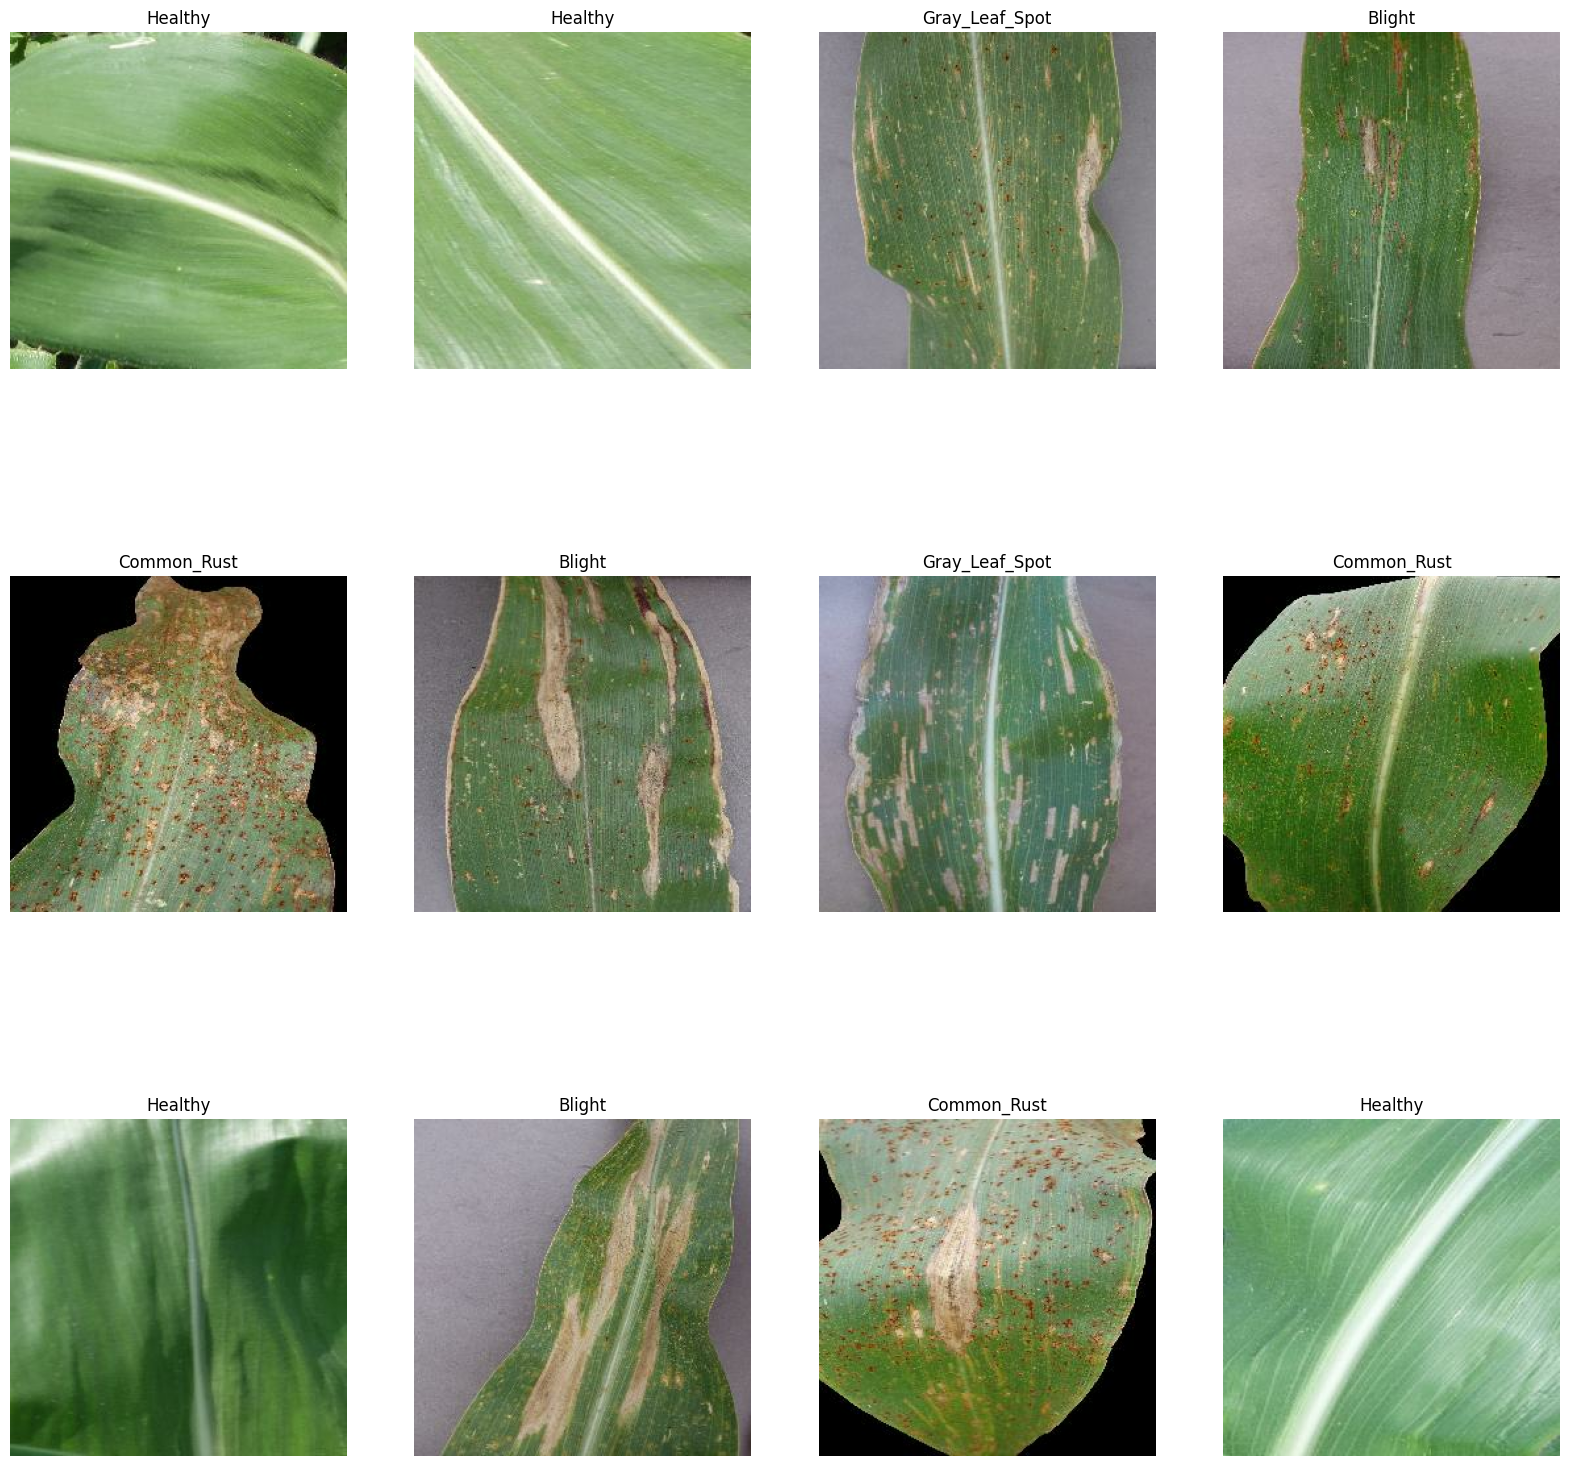

In [ ]:
#Plotting Images
plt.figure(figsize=(20, 20))
# dataset.take(count) : Creates a Dataset with at most 'count' elements(batch) from the dataset
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1) # many plots at a time =>subpots
        plt.imshow(image_batch[i].numpy().astype("uint8")) #converting all data
        #of image into numpy and than to intiger type as they were in float.
        plt.title(class_names[labels_batch[i]])# title of the class_name of image
        plt.axis("off")# Hide the values of graph

#Data Augementation:

In [ ]:
# Function for Splitting the data
def get_dataset_partitions_tf(ds, train_split=0.8,
                              val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print("Size of Data is: ",len(dataset))
print("\nLength/Batch Size of Training Dataset is",len(train_ds))
print("\nLength/Batch Size of Validation Dataset is",len(val_ds))
print("\nLength/Batch Size of Testing Dataset is",len(test_ds))

Size of Data is:  132

Length/Batch Size of Training Dataset is 105

Length/Batch Size of Validation Dataset is 13

Length/Batch Size of Testing Dataset is 14


### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before input of the images to network, we should be **resizing it** to the desired size.

Moreover, to **improve model performance**, we should **normalize the image pixel value** (keeping them in range 0 and 1 by dividing by 256).

To be safe, we do a resize (256,256), which is useful if the dataset was change.

### IMAGE Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    # Randomly flip the images horizontally and vertically
    layers.RandomFlip("horizontal_and_vertical"),

    # Randomly rotate images by up to 45 degrees (0.5 radians)
    layers.RandomRotation(0.5),

    # Randomly change the brightness of images
    #layers.RandomBrightness(factor=0.2),

    # Randomly change the contrast of images
    #layers.RandomContrast(factor=0.2),

    # Randomly change the saturation of images
    #layers.RandomSaturation(factor=0.2),

    # Randomly change the hue of images
    #layers.RandomHue(factor=0.2),

    # Randomly zoom into images
    #layers.RandomZoom(height_factor=0.2, width_factor=0.2),

    # Randomly crop images
    #layers.RandomCrop(height=128, width=128),  # Example dimensions, adjust as needed

    # Apply random noise (manual implementation)
    # Note: This requires a custom layer or function to add noise manually,
    # as TensorFlow does not have a built-in RandomNoise layer.

    # Randomly apply Gaussian blur (manual implementation)
    # Note: This also requires a custom implementation.
])

In [ ]:
from tensorflow import keras
def random_saturation(image):
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image

# Define a function to apply random hue
def random_hue(image):
    image = tf.image.random_hue(image, max_delta=0.1)
    return image

    # Create a Sequential model for data augmentation
data_augmentation = keras.Sequential([
    layers.Lambda(random_saturation),
    layers.Lambda(random_hue),
])

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

1. Randomly Flipping images, both Horizontal and Vertical.
2. Randomly rotates input images by factiors of 0.2

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

Because the dataset only have three categories, 1 or them only have less than 200 images, and the other two have 1000 images each, we will need:

1. Simpler architecture: Mean less confolution layers, but consist number of filter to reduce rick of overfitting.

2. Consistent numbers of filter: Use the 64 filters, the one that is less likely to reduce in overfit.

3. Appropriate Output Layer: Model with softmax activation suitable for multi-class classification, this ensure model leanrs the assign probabilities to each class. Decent as handling imbalanced dataset.

#### Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.map(lambda x, y: (data_augmentation(x, training=False), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define input shape
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4  # Number of classes

# Create the model
model = models.Sequential([
    # Assuming resize_and_rescale is defined elsewhere
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),  # Dropout layer before final Dense layer
    layers.Dense(n_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Print model summary
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 4)                     │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 480s 5s/step - accuracy: 0.3945 - loss: 1.2516 - val_accuracy: 0.5986 - val_loss: 0.9412
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 517s 5s/step - accuracy: 0.6160 - loss: 0.9240 - val_accuracy: 0.7957 - val_loss: 0.5373
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 469s 4s/step - accuracy: 0.6894 - loss: 0.7970 - val_accuracy: 0.6346 - val_loss: 0.7843
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 468s 4s/step - accuracy: 0.7365 - loss: 0.6807 - val_accuracy: 0.7861 - val_loss: 0.5842
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 464s 4s/step - accuracy: 0.7601 - loss: 0.6463 - val_accuracy: 0.8317 - val_loss: 0.5300
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 463s 4s/step - accuracy: 0.8196 - loss: 0.5082 - val_accuracy: 0.8630 - val_loss: 0.3791
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 468s 4s/step - accuracy: 0.8348 - loss: 0.4536 - val_accuracy: 0.8750 - val_loss: 0.3349
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 466s 4s/step - accuracy: 0.8440 - loss: 0.4147 - val_accu

Accuracy (training): 41.41% – This shows the percentage of correct predictions on the training data.

It's relatively low, but it's normal for early epochs as the model is still learning.

Loss (training): 1.2378 – This is the model’s error on the training data. Lower is generally better.

Validation Accuracy: 75.72% – This indicates the model's performance on unseen validation data. This is quite high for just the first epoch, suggesting good generalization early on.

Validation Loss: 0.5694 – This is the model's error on the validation data. Again, lower is better.

### Compiling the Model
We use `ADAM` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

1. Loss: Value of loss on training data, Higher loss = prediction are further from the actual values.
2. Accuracy: Value of accuracy on training data, fraction of correctly predicted data points out of the total data point.
3. val Loss: The value of the loss function on the validation data. This metric is used to monitor the generalization ability of the model.
4. val Accuracy: The accuracy of the model on the validation data. It measures how well the model is performing on data that it hasn't seen during training.

In [ ]:
scores = model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9679 - loss: 0.0985


In [ ]:
scores = model.evaluate(train_ds)

105/105 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9554 - loss: 0.1176


In [ ]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 105}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves:


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

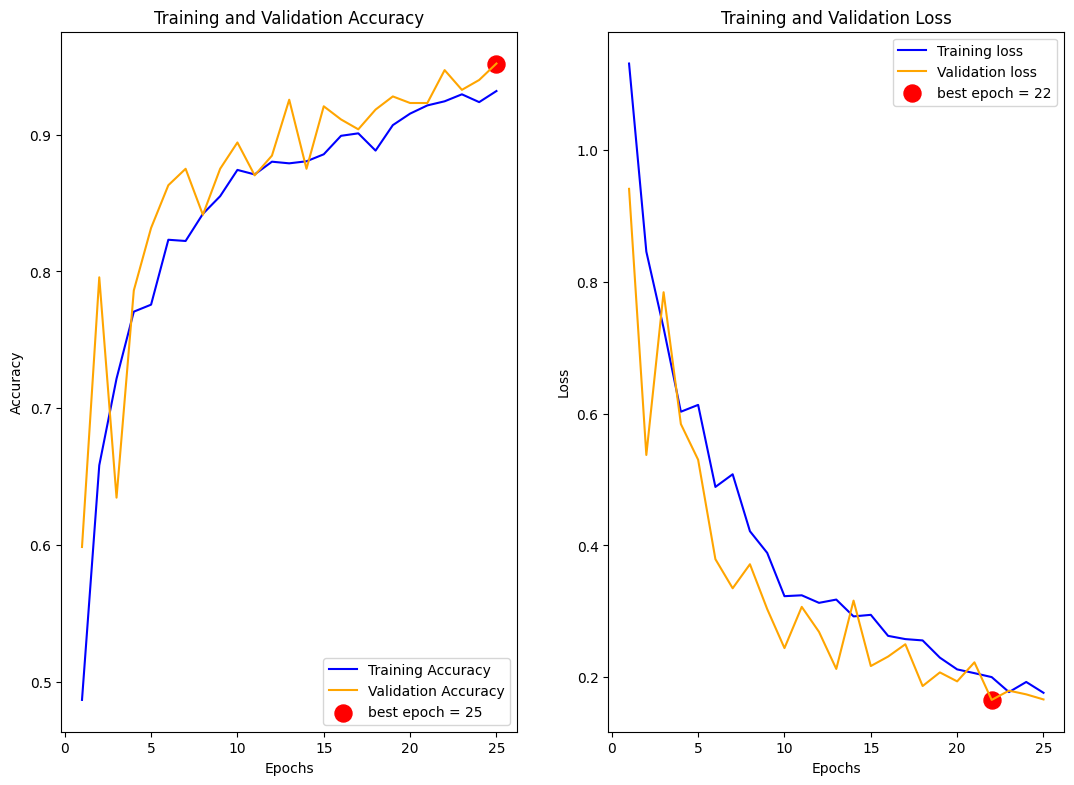

In [ ]:
#Experiment
tr_acc = history.history['accuracy']
tr_loss =  history.history['loss']
val_acc =  history.history['val_accuracy']
val_loss =  history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch = {str(index_loss + 1)}'
acc_label = f'best epoch = {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize=(20, 20))
#plt.style.use('fivethirtyeight')
plt.subplot(2,3,1)
plt.plot(Epochs, tr_acc, 'blue', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'orange', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='red', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.subplot(2,3,2)
plt.plot(Epochs, tr_loss, 'blue', label = 'Training loss')
plt.plot(Epochs, val_loss, 'orange', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='red', label= loss_label)#
plt.title('Training and Validation Loss')
plt.legend(loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.tight_layout
plt.show()

from the result of the 5 cycle, for the training and validation Accuracy:

Model is learning effectively and not overfitting. Suggest model is able to generalize well to unseen data.

The loss validation and training is also dropping on par with each other, same as above.


### Run prediction on a sample image

first image to predict
actual label: Common_Rust
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: Common_Rust


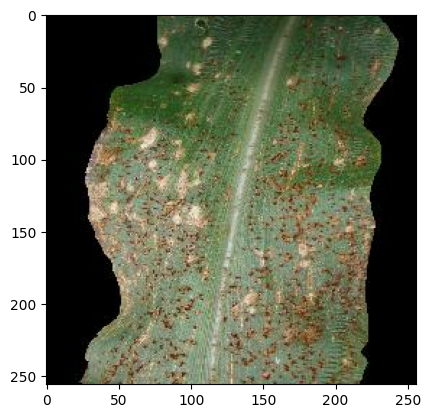

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


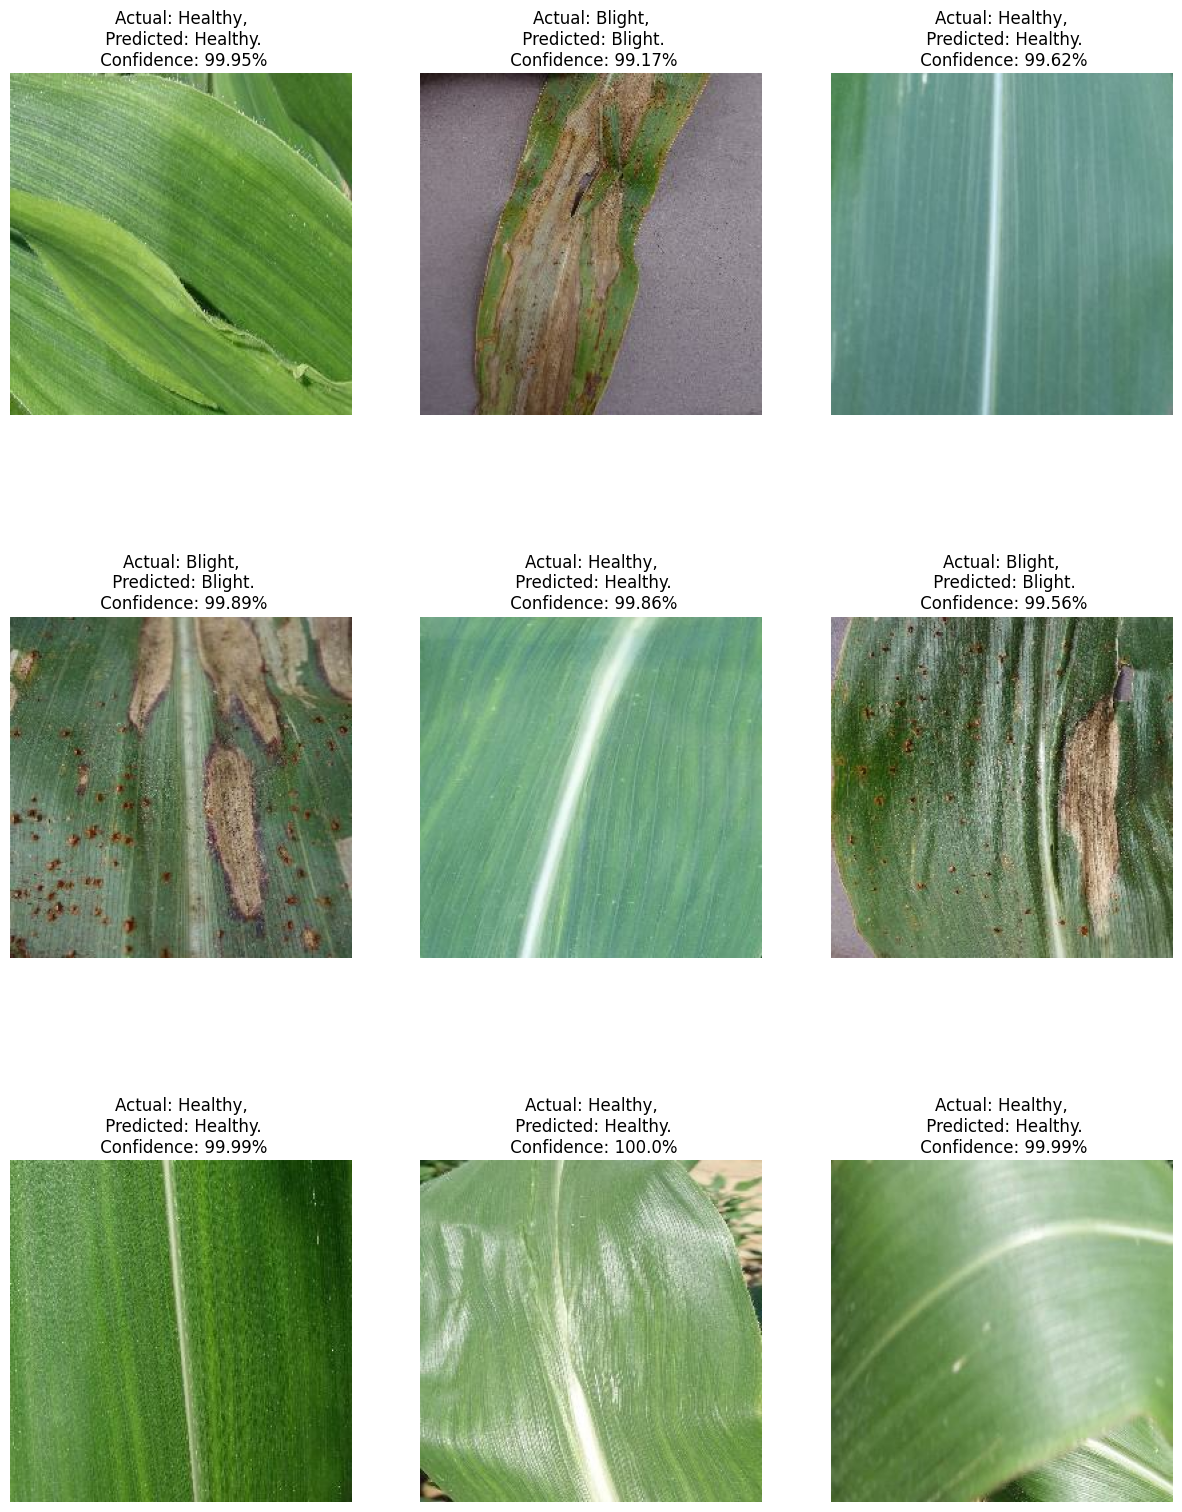

In [ ]:
plt.figure(figsize=(15, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
#Remember to do a model.save('write some name in here') to save the progress and get a pre-train model

In [ ]:
#model.save('Model3_CNN_Epoch30')
model.save('Adam3Model3_CNN_Epoch25')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=Adam3Model3_CNN_Epoch25.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("newadam3model3_25cycle.tflite", 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpakxcqjb8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name='keras_tensor_49')
Output Type:
  TensorSpec(shape=(32, 4), dtype=tf.float32, name=None)
Captures:
  138130249287104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138130249301536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138130249794480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138130249800112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138130249795888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138130249801872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138130249797648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138130249803632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138130249802928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138130249805392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138130249804688